
## Load and Visualize the Data

In [130]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings
from skimage.metrics import structural_similarity as ssim

%matplotlib inline

### DataLoaders

In [131]:
def get_data_loader(image_type, image_dir='C:/Users/ACER/Image-to-Sketch-using-Cycle-GAN/sketches', 
                    image_size=128, batch_size=16, num_workers=0, train_test_split=0.8):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize((image_size, 128)), # resize to 128x128
                                    transforms.ToTensor()])

    # get training directory
    image_path = image_dir + '/'
    train_path = os.path.join(image_path, image_type)

    # split training data into train and test
    dataset = datasets.ImageFolder(train_path, transform)
    train_size = int(train_test_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


In [132]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='photos',batch_size=25)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='sketchs',batch_size=25)

## Display some Training Images


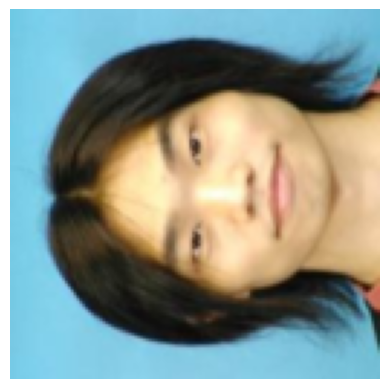

In [133]:
import matplotlib.pyplot as plt
import torchvision

# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # turn off axis for cleaner display

# get some images from dataloader_X
for images, _ in dataloader_X:
    # show the first image in the batch
    imshow(images[3])
    break  # break after showing the first image


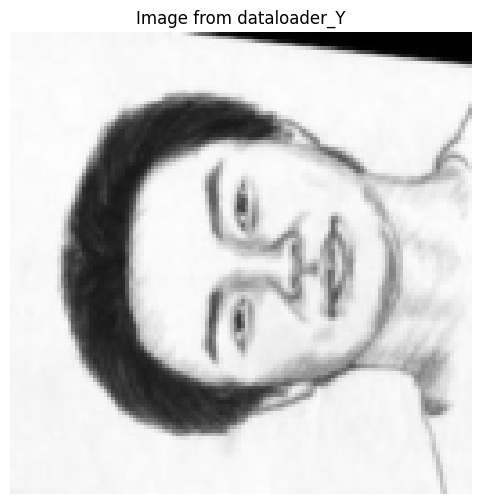

In [134]:
for images_Y, _ in dataloader_Y:
    # Show the first image from dataloader_Y
    fig_Y = plt.figure(figsize=(6, 6))
    imshow(images_Y[10])
    plt.title('Image from dataloader_Y')
    break  # Break after showing the first image from dataloader_Y

In [135]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0157)
Max:  tensor(1.)


In [136]:
# helper scale function
def scale(x, feature_range=(-1, 1)):    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [137]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9686)
Scaled max:  tensor(1.)


---
## Define the Model

In [138]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### The Discriminator


In [139]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

Residual Block

In [140]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()

        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

In [141]:

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## The Generator 

In [142]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
Network

In [143]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [144]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()


Models moved to GPU.


---
### Loss Functions



In [145]:
from skimage.metrics import structural_similarity as ssim
import torch
from torch.autograd import Variable

def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def calculate_ssim(real_im, reconstructed_im):
    # Convert PyTorch tensors to numpy arrays
    real_im_np = real_im.detach().cpu().numpy()
    reconstructed_im_np = reconstructed_im.detach().cpu().numpy()

    # Calculate SSIM
    ssim_value = ssim(real_im_np, reconstructed_im_np, win_size=3, data_range=1.0)
    
    return ssim_value


def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Optimizers


In [146]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
#lr=0.00000001
beta1=0
beta2=0.99 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# function to save weights

In [147]:
def save_weights():
    torch.save(D_X.state_dict(),'weights/D_X.pth')
    torch.save(G_XtoY.state_dict(),'weights/G_XtoY.pth')
    torch.save(D_Y.state_dict(),'weights/D_Y.pth')
    torch.save(G_YtoX.state_dict(),'weights/G_YtoX.pth')    

---

## Training a CycleGAN

In [148]:
# import save code
from helpers import save_samples, checkpoint

In [149]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=1000):
    print_every = 1
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling.
    # These are images that are held constant throughout training,
    # that allow us to inspect the model's performance.
    fixed_X = next(iter(test_dataloader_X))[0]
    fixed_Y = next(iter(test_dataloader_Y))[0]
    fixed_X = scale(fixed_X)  # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    batches_per_epoch = min(len(dataloader_X), len(dataloader_Y))
    
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)

    for epoch in range(1, n_epochs + 1):
        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = next(iter_X)
        images_X = scale(images_X)  # make sure to scale to a range -1 to 1
        images_Y, _ = next(iter_Y)
        images_Y = scale(images_Y)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)

        # Train the discriminators
        d_x_optimizer.zero_grad()
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X.detach())
        D_X_fake_loss = fake_mse_loss(out_x)
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        d_y_optimizer.zero_grad()
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y.detach())
        D_Y_fake_loss = fake_mse_loss(out_y)
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        # Train the generators
        g_optimizer.zero_grad()
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=5)

        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=5)

        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()

        ssim_value = calculate_ssim(images_X, reconstructed_X) + \
                     calculate_ssim(images_Y, reconstructed_Y)

        # Print the log info
# Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f} | SSIM: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item(), ssim_value.item()))

        sample_every = 100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval()
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=25)
            G_YtoX.train()
            G_XtoY.train()
            save_weights()
    return losses


In [150]:
n_epochs = 50 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [    1/   50] | d_X_loss: 1.1502 | d_Y_loss: 1.8448 | g_total_loss: 8.2422 | SSIM: -0.0006
Epoch [    2/   50] | d_X_loss: 1.7671 | d_Y_loss: 1.3193 | g_total_loss: 10.8995 | SSIM: 0.0012
Epoch [    3/   50] | d_X_loss: 1.4420 | d_Y_loss: 1.3007 | g_total_loss: 8.4320 | SSIM: 0.0046
Epoch [    4/   50] | d_X_loss: 1.3132 | d_Y_loss: 0.9404 | g_total_loss: 10.9600 | SSIM: 0.0046
Epoch [    5/   50] | d_X_loss: 1.1581 | d_Y_loss: 0.6533 | g_total_loss: 8.4955 | SSIM: 0.0301
Epoch [    6/   50] | d_X_loss: 1.0751 | d_Y_loss: 0.6354 | g_total_loss: 10.7069 | SSIM: 0.0370
Epoch [    7/   50] | d_X_loss: 0.5639 | d_Y_loss: 0.7333 | g_total_loss: 7.2769 | SSIM: 0.0706
Epoch [    8/   50] | d_X_loss: 0.5879 | d_Y_loss: 1.1477 | g_total_loss: 10.6480 | SSIM: 0.1147
Epoch [    9/   50] | d_X_loss: 0.4229 | d_Y_loss: 1.1768 | g_total_loss: 6.8726 | SSIM: 0.0987
Epoch [   10/   50] | d_X_loss: 0.4575 | d_Y_loss: 1.0593 | g_total_loss: 9.7635 | SSIM: 0.1935
Epoch [   11/   50] | d_X_loss: 0.4

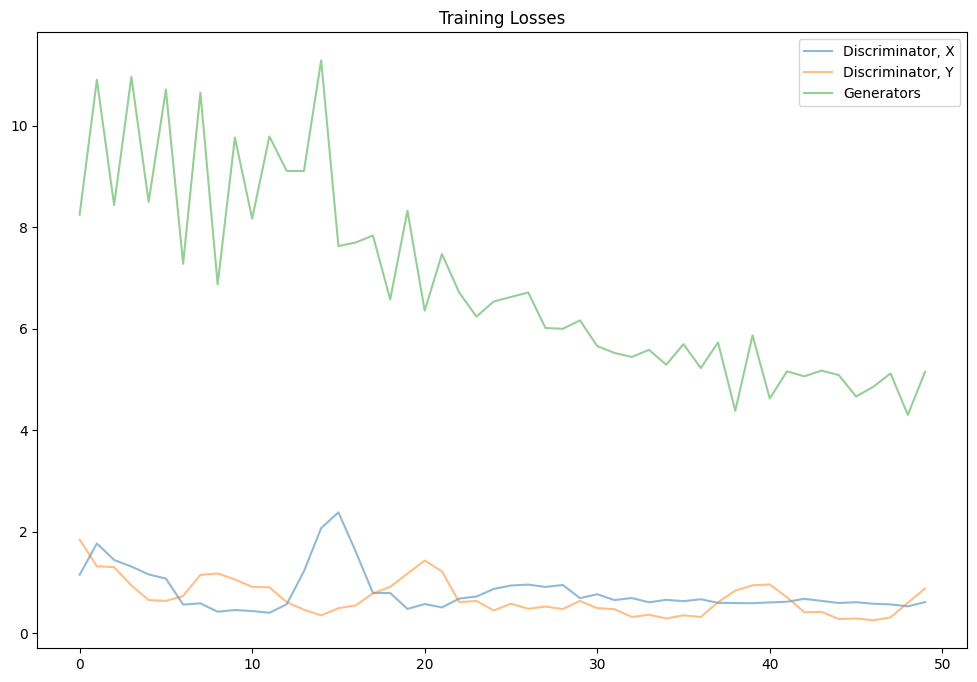

In [151]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!


In [152]:
import matplotlib.pyplot as plt
import os

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in the Y to X samples
    try: 
        y2x = plt.imread(path_YtoX)
    except FileNotFoundError:
        print('File not found. Invalid number of iterations.')
        return
    
    # Display the Y to X samples
    plt.figure(figsize=(8, 8))
    plt.imshow(y2x)
    plt.title('Transformation')
    plt.axis('off')
    plt.show()


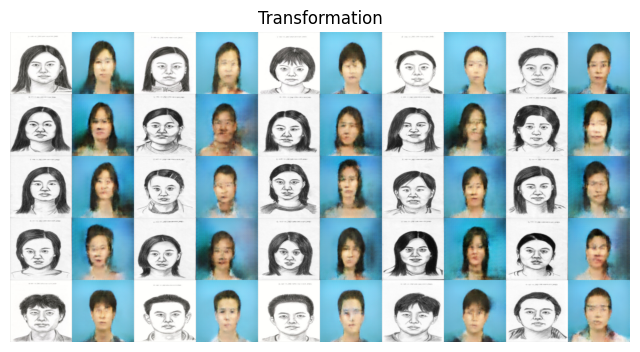

In [153]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')